<a href="https://colab.research.google.com/github/terencebeauj/mle_project/blob/master/Modele_final_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import SimpleRNN, Dense, Input, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import SGD, Adam

In [ ]:
cd /content/drive/MyDrive/Colab_Notebooks/Projet/Dossier_final/data

/content/drive/MyDrive/Colab_Notebooks/Projet/Dossier_final/data


In [ ]:
df = pd.read_csv("./final_preprocess_df.csv", index_col=0, sep=",", encoding="utf8")

df["dateT_E"] = pd.to_datetime(df.dateT_E)
df["date"] = pd.to_datetime(df.date)

df.head()

,dateT_E,dateT_S,delta_time,code,age,sex,tri,label,decision,date,year,month,day,week_day,hour,min,date_S,date_S_AN,date_S_MOIS,date_S_JOUR,date_S_H,date_S_MN,tri_is_missing,identity_is_missing,sortie_is_zero,ferie_chome,school vacation
0,2020-06-29 18:07:00,2020-06-30 20:50:00,26.72,T601,37.7,F,3,Urgence moyenne,Patient admis,2020-06-29,2020,6,29,0,18,7,2020-06-30,2020,6,30,20,50,0,0,0,travail,non
1,2019-10-05 08:05:00,2019-10-06 10:45:00,26.67,T601,26.5,F,3,Urgence moyenne,Patient non admis,2019-10-05,2019,10,5,5,8,5,2019-10-06,2019,10,6,10,45,0,0,0,travail,non
2,2017-01-21 20:30:00,2017-01-22 23:00:00,26.50,T601,25.8,M,4,Lesion stable,Patient décédé,2017-01-21,2017,1,21,5,20,30,2017-01-22,2017,1,22,23,0,0,0,0,travail,oui
3,2017-02-27 13:45:00,2017-02-28 16:00:00,26.25,T601,58.5,M,3,Urgence moyenne,Patient admis,2017-02-27,2017,2,27,0,13,45,2017-02-28,2017,2,28,16,0,0,0,0,travail,non
4,2017-01-05 12:40:00,2017-01-06 14:49:00,26.15,T601,66.4,M,4,Lesion stable,Patient admis,2017-01-05,2017,1,5,3,12,40,2017-01-06,2017,1,6,14,49,0,0,0,FERIE,non


On classe les données dans l'ordre pour le modele de time series

In [ ]:
df = df.sort_values("dateT_E")

In [ ]:
df.tail()

,dateT_E,dateT_S,delta_time,code,age,sex,tri,label,decision,date,year,month,day,week_day,hour,min,date_S,date_S_AN,date_S_MOIS,date_S_JOUR,date_S_H,date_S_MN,tri_is_missing,identity_is_missing,sortie_is_zero,ferie_chome,school vacation
129792,2021-04-30 23:03:00,2021-05-01 00:39:00,1.60,T601,44.3,F,4,Lesion stable,Patient non admis,2021-04-30,2021,4,30,4,23,3,2021-05-01,2021,5,1,0,39,0,0,0,travail,non
179892,2021-04-30 23:06:00,2021-04-30 23:51:00,0.75,T602,6.0,M,3,Urgence moyenne,Patient non admis,2021-04-30,2021,4,30,4,23,6,2021-04-30,2021,4,30,23,51,0,0,0,travail,non
77097,2021-04-30 23:25:00,2021-05-01 02:27:00,3.03,T601,15.8,M,2,Urgence vraie,Patient admis,2021-04-30,2021,4,30,4,23,25,2021-05-01,2021,5,1,2,27,0,0,0,travail,non
150428,2021-04-30 23:51:00,2021-05-01 01:04:00,1.22,T601,22.1,M,3,Urgence moyenne,Patient non admis,2021-04-30,2021,4,30,4,23,51,2021-05-01,2021,5,1,1,4,0,0,0,travail,non
172416,2021-04-30 23:53:00,2021-05-01 00:45:00,0.87,T602,0.1,M,3,Urgence moyenne,Patient admis,2021-04-30,2021,4,30,4,23,53,2021-05-01,2021,5,1,0,45,0,0,0,travail,non


On crée une série pour passer au modele

In [ ]:
time_serie = df.groupby(["date"]).count().code
time_serie.head(20)

date
2016-01-01    174
2016-01-02    157
2016-01-03    129
2016-01-04    142
2016-01-05    133
2016-01-06    129
2016-01-07    134
2016-01-08    135
2016-01-09    144
2016-01-10    138
2016-01-11    129
2016-01-12    138
2016-01-13    113
2016-01-14    114
2016-01-15    130
2016-01-16    126
2016-01-17    140
2016-01-18    130
2016-01-19    106
2016-01-20    127
Name: code, dtype: int64

In [ ]:
time_serie.tail()

date
2021-04-26    134
2021-04-27    102
2021-04-28    114
2021-04-29    111
2021-04-30    129
Name: code, dtype: int64

On crée 2 série différentes, une avant covid, l'autre apres.

In [ ]:
time_serie_before_covid = time_serie.loc[:"2019-12-31"]
time_serie_covid = time_serie.loc["2020-01-01":]

time_serie_before_covid.tail()

date
2019-12-27    133
2019-12-28    123
2019-12-29    119
2019-12-30    141
2019-12-31    107
Name: code, dtype: int64

In [ ]:
time_serie_covid.tail()

date
2021-04-26    134
2021-04-27    102
2021-04-28    114
2021-04-29    111
2021-04-30    129
Name: code, dtype: int64

**Étude avant le Covid**

On préprocesse les données avamt de les passer au modele, car les modeles de time series acceptent en entier des vecteurs en 3D.

On prendre un  T = 7, c-à-d qu'on se servira des données des 7 jours antécédents pour prédire la valeur de flux du jour suivant.

In [ ]:
T = 7
D = 1
X = []
Y = []
for t in range(len(time_serie_before_covid) - T):
  x = time_serie_before_covid[t:t+T]
  X.append(x)
  y = time_serie_before_covid[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print(X.shape, Y.shape)

(1454, 7, 1) (1454,)


Pour le modele, on utilise une cellule RNN et un neurone dans la couche de sortie avec une fonction d'activation linéaire.

On utilisera l'optimiseur Adam avec la fonction de loss MSE.

On prendra la moitié des données pour l'entraînement, et la moitié restante pour les tests.

In [ ]:
i = Input(shape=(T, 1))
x = SimpleRNN(5, activation=LeakyReLU())(i)
x = Dense(1)(x)

model = Model(i, x)
model.compile(optimizer=Adam(lr=0.01),
              loss="mse",
              metrics=["mape"])

history = model.fit(X[:-N//2],
                    Y[:-N//2],
                    validation_data=(X[-N//2:], Y[-N//2:]),
                    epochs=50)

Epoch 1/50
23/23 [==============================] - 2s 27ms/step - loss: 3604.1921 - mape: 38.3590 - val_loss: 410.2462 - val_mape: 12.3695
Epoch 2/50
23/23 [==============================] - 0s 8ms/step - loss: 492.4644 - mape: 13.3872 - val_loss: 403.9155 - val_mape: 12.4761
Epoch 3/50
23/23 [==============================] - 0s 10ms/step - loss: 473.8448 - mape: 13.7033 - val_loss: 394.7231 - val_mape: 12.0257
Epoch 4/50
23/23 [==============================] - 0s 9ms/step - loss: 455.4617 - mape: 13.1897 - val_loss: 372.3287 - val_mape: 11.7804
Epoch 5/50
23/23 [==============================] - 0s 9ms/step - loss: 429.5140 - mape: 12.6107 - val_loss: 363.3708 - val_mape: 11.7041
Epoch 6/50
23/23 [==============================] - 0s 10ms/step - loss: 433.0113 - mape: 12.8667 - val_loss: 353.4065 - val_mape: 11.5479
Epoch 7/50
23/23 [==============================] - 0s 9ms/step - loss: 415.4318 - mape: 12.6756 - val_loss: 316.6292 - val_mape: 10.9693
Epoch 8/50
23/23 [============

On peut constater que les loss d'entraînement et de validation convergent vers une asymptote horizontale. C'est un bon signe pour notre modele, notamment par rapport à l'overfitting.

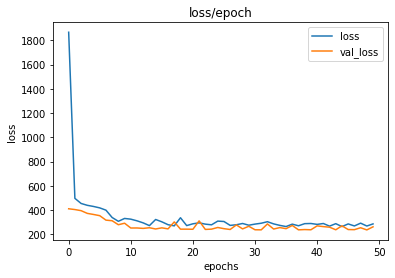

In [ ]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("loss/epoch")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show();

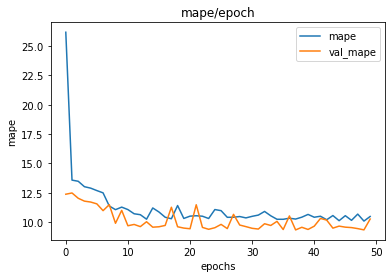

In [ ]:
plt.plot(history.history["mape"], label="mape")
plt.plot(history.history["val_mape"], label="val_mape")
plt.legend()
plt.title("mape/epoch")
plt.xlabel("epochs")
plt.ylabel("mape")
plt.show()

In [ ]:
results = model.evaluate(X[-N//2:], Y[-N//2:])
print(f"MAPE: {results[1]:.2f}")

23/23 [==============================] - 0s 2ms/step - loss: 261.4766 - mape: 10.2551
MAPE: 10.26


On peut visualiser ci-dessous les courbes des valeurs réelles et des prédictions.

Mis à part les valeurs présentes aux pics, on peut constater que le modele approxime bien les données, ce qui correspond bien avec notre MAPE de 10.26%.

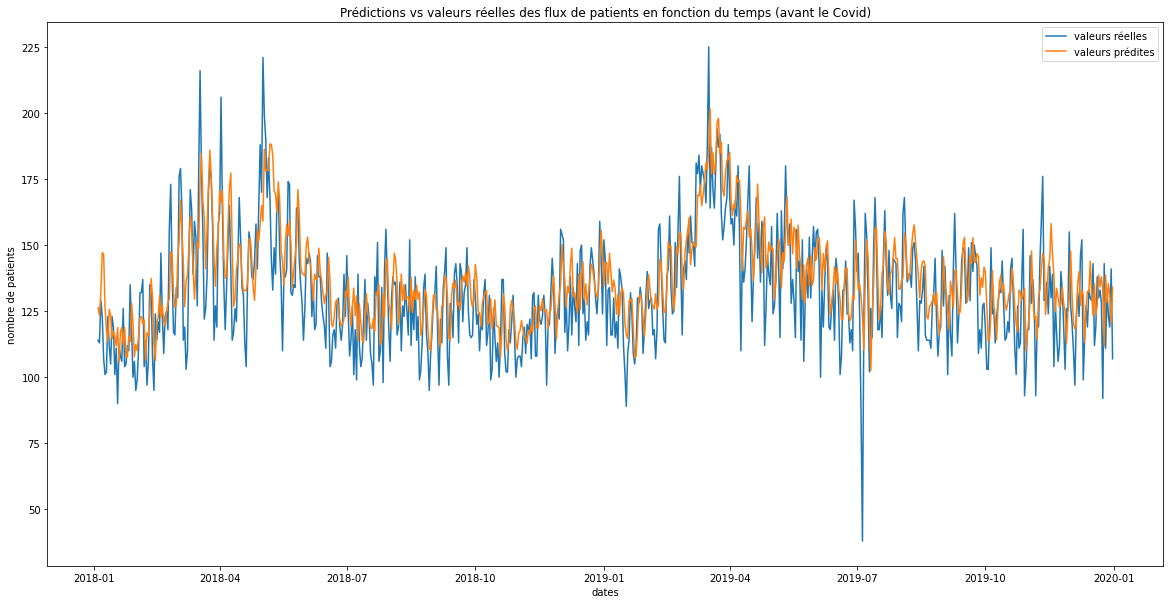

In [ ]:
X_test = X[-N//2:]
y_pred = model.predict(X_test)

plt.figure(figsize=(20, 10))
plt.plot(list(time_serie_before_covid.index[-N//2:]), Y[-N//2:], label="valeurs réelles")
plt.plot(list(time_serie_before_covid.index[-N//2:]),y_pred, label="valeurs prédites")
plt.legend()
plt.title("Prédictions vs valeurs réelles des flux de patients en fonction du temps (avant le Covid)")
plt.xlabel("dates")
plt.ylabel("nombre de patients")
plt.show();

**Étude durant le COVID**

On prépare les matrices pour le modele.

In [ ]:
T = 7
D = 1
X = []
Y = []
for t in range(len(time_serie_covid) - T):
  x = time_serie_covid[t:t+T]
  X.append(x)
  y = time_serie_covid[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print(X.shape, Y.shape)

(479, 7, 1) (479,)


On utilise le même modele avec le même optimiseur et une métrique identique.

In [ ]:
i = Input(shape=(T, 1))
x = SimpleRNN(5, activation=LeakyReLU())(i)
x = Dense(1)(x)

model = Model(i, x)
model.compile(optimizer=Adam(lr=0.01),
              loss="mse",
              metrics=["mape"])

history = model.fit(X[:-N//2],
                    Y[:-N//2],
                    validation_data=(X[-N//2:], Y[-N//2:]),
                    epochs=50)

Epoch 1/50
8/8 [==============================] - 1s 37ms/step - loss: 24660.4434 - mape: 128.7217 - val_loss: 22740.3887 - val_mape: 119.2194
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 20046.0931 - mape: 116.5428 - val_loss: 18788.9941 - val_mape: 108.1266
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 15673.8901 - mape: 105.5363 - val_loss: 15033.0928 - val_mape: 96.4096
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 12798.1331 - mape: 93.2164 - val_loss: 10958.7432 - val_mape: 81.8274
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 8927.8252 - mape: 77.4470 - val_loss: 6222.5654 - val_mape: 60.6502
Epoch 6/50
8/8 [==============================] - 0s 12ms/step - loss: 4441.4191 - mape: 53.4996 - val_loss: 1415.5409 - val_mape: 25.5981
Epoch 7/50
8/8 [==============================] - 0s 12ms/step - loss: 607.6332 - mape: 17.1431 - val_loss: 934.0272 - val_mape: 22.3247
Epoch 8/50
8/8 [

On a une bonne convergence des fonctions de loss, le modele a donc moins l'occasion d'overfitter.

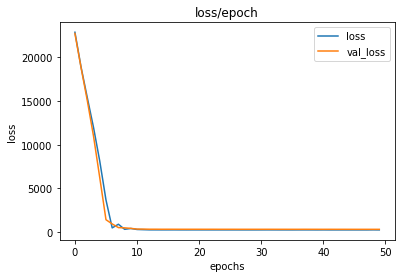

In [ ]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("loss/epoch")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show();

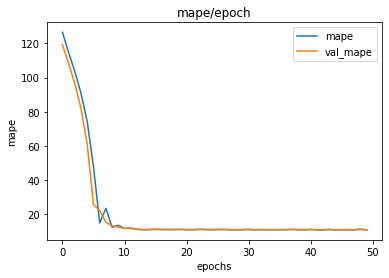

In [ ]:
plt.plot(history.history["mape"], label="mape")
plt.plot(history.history["val_mape"], label="val_mape")
plt.legend()
plt.title("mape/epoch")
plt.xlabel("epochs")
plt.ylabel("mape")
plt.show()

On a une MAPE de 10.91%

In [ ]:
results = model.evaluate(X[-N//2:], Y[-N//2:])
print(f"MAPE: {results[1]:.2f}")

8/8 [==============================] - 0s 2ms/step - loss: 315.2382 - mape: 10.9146
MAPE: 10.91


On peut voir ci-dessous les courbes des prédictions et des valeurs réelles

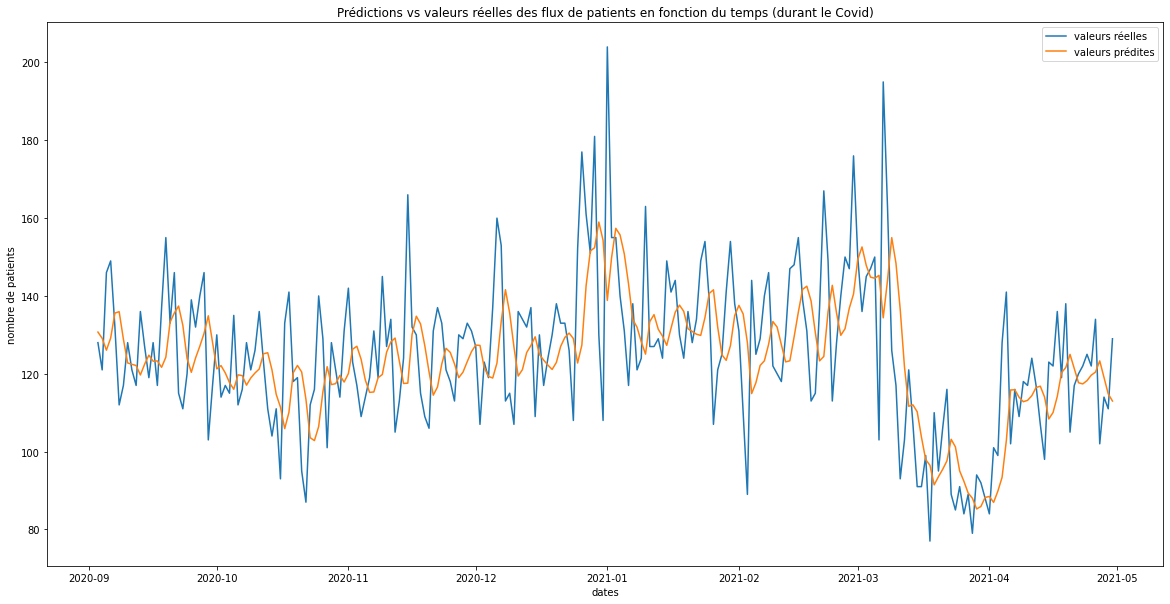

In [ ]:
X_test = X[-N//2:]
y_pred = model.predict(X_test)

plt.figure(figsize=(20, 10))

plt.plot(list(time_serie_covid.index[-N//2:]), Y[-N//2:], label="valeurs réelles")
plt.plot(list(time_serie_covid.index[-N//2:]),y_pred, label="valeurs prédites")
plt.legend()
plt.title("Prédictions vs valeurs réelles des flux de patients en fonction du temps (durant le Covid)")
plt.xlabel("dates")
plt.ylabel("nombre de patients")
plt.show();